# MMPBSA Version 1.7
ToDo:
- Figure out a better way to output TdS
- process traj pbc with or not gmx mda
- optimize the calculation speed
- normal mode analysis
- 
- use different atom radius
- traj processed by mda (pbc)
- optimize the workflow
- optimize the apbs parallel speed
- parallel todo: detect unused cpu core and bind 
- calculate memory useage to generating warning

LOG:
- support Debye Hukel correclation 2023/03/25
- support entropy calcultaion IE 2023/03/21
- support surface Surface Electrostatic Potential Calculation 2023/03/20
- support savesubplot 2023/03/19
- support tpr dump file or use gromacs to generate out file
- in parallel 2023/03/19 
    - This function only works in py file and cant be used in jupyter
    - bind each apbs task to different cpu core (default from the last core index)
    - both thread and Multiprocessing are tested, In comparsion, multiprocess behaviored well
- output png 2023/03/18
- use index.ndx to  designate groups 2023/03/17
- support APBS to do pbsa 2023/03/17
- the basic calculation of MM energy is done
- use mda to read traj
- use radbondi from amber instead of calculated radius
- residue energy decompose 2023/3/12
- the calculation speed is optimized 8s->0.1s
- tricks: residue and Ligand energy is 50/50
- every frame MM energy data was output to xlsx file

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import MultipleLocator
import pandas as pd
import re
import math
import MDAnalysis as mda
import os
from prettytable import PrettyTable
from datetime import datetime

In [2]:
dt=100000 # ps

tprpath="1ebz/topol.tpr"    # provide tpr or tpr dump file(.out)
indexpath="1ebz/index.ndx"
xtcpath="1ebz/traj3.xtc"

# 如果提供了蛋白配体组名，则不使用组index
# 如果使用组index，则将组名改为空("")
ligidx=2   
proidx=1

liggn=""      # 配体组名
progn=""      # 蛋白组名


# elec
MGset="mg-auto"
temp=298.15
pdie=2         # 溶质介电常数
sdie=78.54     # 溶剂介电常数, 真空1, 水78.54
pbm="npbe"     # PB方程求解方法, lpbe(线性), npbe(非线性), smbpe(大小修正)
bcfl="mdh"     # 粗略格点PB方程的边界条件, zero, sdh/mdh(single/multiple Debye-Huckel), focus, map       
srfm="smol"    # 构建介质和离子边界的模型, mol(分子表面), smol(平滑分子表面), spl2/4(三次样条/7阶多项式)   
chgm="spl4"    # 电荷映射到格点的方法, spl0/2/4, 三线性插值, 立方/四次B样条离散   
swin=0.3       # 立方样条的窗口值, 仅用于 srfm=spl2/4   
srad=1.4       # 溶剂探测半径  
sdens=10       # 表面密度, 每A^2的格点数, (srad=0)或(srfm=spl2/4)时不使用  
pcharge=1
pconc=0.15
pradius=0.95
ncharge=-1
nconc=0.15
nradius=1.81

# sasa
atemp=298.15
asrfm="sacc"
aswin=0.3
asrad=1.4
agamma=1
apress=0
abconc=0
asdens=10
adpos=0.2
agridx=0.1
agridy=0.1
agridz=0.1


gridType=1			# 格点大小 grid (0:GMXPBSA 1:psize)

cfac=3				# 分子尺寸到粗略格点的放大系数
					# Factor to expand mol-dim to get coarse grid dim
fadd=10				# 分子尺寸到细密格点的增加值(A)
					# Amount added to mol-dim to get fine grid dim (A)
df=0.5				# 细密格点间距(A) The desired fine mesh spacing (A)

gamma=0.02267788
offset=3.84928

precision=4          # 保留小数位数
E0=8.854187817E-12   # 真空介电常数 F/m
KB=1.380649E-23      # 玻尔兹曼常数 J/K
EE=1.602176634E-19   # 电子电量 C
NA=6.02E23         # 阿伏伽德罗常数
MTA=1E10            # 米换算成埃
# gamma=0.02267788
# offset=3.84928

In [3]:
# 读取蛋白-配体体系tpr文件
if tprpath.strip().split(".")[-1]=="tpr":
    os.system("gmx dump -s {} > tpr.out".format(tprpath))
    tprpath="tpr.out"
elif tprpath.strip().split(".")[-1]=="out":
    tprpath=tprpath
else:
    print("Please provide correct tpr file (supported: tpr or tpr-dump-file(out))")

with open(tprpath) as f:
    lines=f.readlines()

In [4]:
# 读取index
with open(indexpath) as idxf:
    idxflines=idxf.readlines()
idxarr=[]
idxnlist={}
count=0
for idxfline in idxflines:
    tmp=re.findall(re.compile(r"\[([\s0-9a-zA-Z]+)\]"),idxfline)
    if tmp !=[]:
        idxarr.append(idxflines.index(idxfline))
        idxnlist[tmp[0].strip()]=count
        count=count+1
    
liglist=np.array(0)
prolist=np.array(0)
comlist=np.array(0)
try:
    if liggn=="" or progn=="":
        if ligidx+1<len(idxarr):
            for i in range(idxarr[ligidx]+1,idxarr[ligidx+1]):
                liglist=np.insert(liglist,-1,idxflines[i].split())

        elif ligidx+1==len(idxarr):
            for i in range(idxarr[ligidx]+1,len(idxflines)):
                liglist=np.insert(liglist,-1,idxflines[i].split())
        else:
            print('ligand index in index.ndx error')

        liglist=np.delete(liglist,-1)-1
        liglist.sort()
            
        if proidx+1<len(idxarr):
            for i in range(idxarr[proidx]+1,idxarr[proidx+1]):
                prolist=np.insert(prolist,-1,idxflines[i].split())

        elif proidx+1==len(idxarr):
            for i in range(idxarr[proidx]+1,len(idxflines)):
                prolist=np.insert(prolist,-1,idxflines[i].split())
        else:
            print('ligand index in index.ndx error')
    else:
        if idxnlist[liggn]+1<len(idxarr):
            for i in range(idxarr[idxnlist[liggn]]+1,idxarr[idxnlist[liggn]+1]):
                liglist=np.insert(liglist,-1,idxflines[i].split())

        elif idxnlist[liggn]+1==len(idxarr):
            for i in range(idxarr[idxnlist[liggn]]+1,len(idxflines)):
                liglist=np.insert(liglist,-1,idxflines[i].split())
        else:
            print('ligand index in index.ndx error')

        liglist=np.delete(liglist,-1)-1
        liglist.sort()
            
        if idxnlist[progn]+1<len(idxarr):
            for i in range(idxarr[idxnlist[progn]]+1,idxarr[idxnlist[progn]+1]):
                prolist=np.insert(prolist,-1,idxflines[i].split())

        elif idxnlist[progn]+1==len(idxarr):
            for i in range(idxarr[idxnlist[progn]]+1,len(idxflines)):
                prolist=np.insert(prolist,-1,idxflines[i].split())
        else:
            print('ligand index in index.ndx error')   
except KeyError:
    print("Please provide the valid protein or ligand group name ")


prolist=np.delete(prolist,-1)-1
prolist.sort()

comlist=np.insert(prolist,-1,liglist)
comlist.sort()


In [5]:
# get all atoms ==gro
# 1. find all molblocks
molblockstart=[]
box=[]
for line in lines:
    if line.startswith("   molblock"):
        molblockstart.append(lines.index(line))
    if line.startswith("box (3x3):"):
        box.append(re.findall(re.compile(r"=\{([\,\s\+\-e\.0-9]+)\}"),lines[lines.index(line)+1])[0].split(","))
        box.append(re.findall(re.compile(r"=\{([\,\s\+\-e\.0-9]+)\}"),lines[lines.index(line)+2])[0].split(","))
        box.append(re.findall(re.compile(r"=\{([\,\s\+\-e\.0-9]+)\}"),lines[lines.index(line)+3])[0].split(","))
totalatom={}
for i,j in enumerate(molblockstart):
    totalatom[re.findall(re.compile(r"\s[0-9]+\s\"([0-9a-zA-Z\s\-\_\+]+)\""),lines[j+1])[0]]=re.findall(re.compile(r"\s=\s([0-9]+)"),lines[j+2])[0]

In [6]:
# 读取坐标
for line in lines:
    if line.startswith("x ("):
        xlen=re.findall(re.compile(r"\s\(([0-9]+)x"),line)
        xstart=lines.index(line)+1
        xend=int(xlen[0])+xstart
coord=[re.findall(re.compile(r"\{([\s0-9a-zA-Ze\.\+\-\,]+)\}"),line)[0].split(",") for line in lines[xstart:xend]]
coord=pd.DataFrame(coord,columns=["x","y","z"])

In [7]:
# 修改resindex思路，根据循环
# 先设置一个初始residx_tmp=0,在第一层循环时即对蛋白序列都只加上0
# 第二次循环时，residx_tmp取存储在tmp中的最后一个残基index进行累加
# 对于sol及NA离子，通过在循环内添加countindx实现自增
tmp=[]
type=re.compile(r"type=([\s0-9]+)")
mass=re.compile(r"m=([\s\.0-9e\+\-]+)")
charge=re.compile(r"q=([\s\.0-9e\+\-]+)")
adx=re.compile(r"atom\[([\s0-9]+)")
resid=re.compile(r"resind=([\s0-9\+\-]+)")
atn=re.compile(r"atomnumber=([\s0-9\+\-]+)")
atomname=re.compile(r"{name=\"([A-Za-z0-9\*\_]+)\"")
atomtype=re.compile(r"{name=\"([A-Za-z0-9\*\_]+)\",")
residuestart=[]
residx_tmp=0
for line in lines:
    for i,j in enumerate(totalatom):
        if line.startswith("      name="+"\""+j+"\""):
            Len=re.findall(re.compile(r"\s\(([0-9]+)"),lines[lines.index(line)+2])
            start=lines.index(line)+3
            end=start+int(Len[0])
            resn={}
            resns=re.findall(re.compile(r"\s\(([0-9]+)\)"),lines[start+3*int(Len[0])+2])[0]
            for res in range(int(resns)):
                resn[res]=re.findall(re.compile(r"{name=\"([a-zA-Z0-9\_\+\*]+)"),lines[start+3*int(Len[0])+res+3])[0]
            if int(totalatom[j])!=1:
                coutindx=1
                for n in range(int(totalatom[j])):
                    count=1
                    for m in lines[start:end]:
                        tmp.append([
                            re.findall(type,m)[0].split()[0],
                            re.findall(mass,m)[0].split()[0],
                            re.findall(charge,m)[0].split()[0],
                            re.findall(adx,m)[0].split()[0],
                            int(re.findall(resid,m)[0].split()[0])+coutindx+residx_tmp,
                            re.findall(atn,m)[0].split()[0],
                            re.findall(atomname,lines[start+int(Len[0])+count])[0].split()[0],
                            re.findall(atomtype,lines[start+2*int(Len[0])+count+1])[0].split()[0],
                            resn[int(re.findall(resid,m)[0].split()[0])],
                            j,
                        ])
                        count=count+1
                    coutindx=coutindx+1
                residx_tmp=tmp[-1][4]
            else:
                count=1
                for m in lines[start:end]:
                        tmp.append([
                            re.findall(type,m)[0].split()[0],
                            re.findall(mass,m)[0].split()[0],
                            re.findall(charge,m)[0].split()[0],
                            re.findall(adx,m)[0].split()[0],
                            int(re.findall(resid,m)[0].split()[0])+1+residx_tmp,
                            re.findall(atn,m)[0].split()[0],
                            re.findall(atomname,lines[start+int(Len[0])+count])[0].split()[0],
                            re.findall(atomtype,lines[start+2*int(Len[0])+count+1])[0].split()[0],
                            resn[int(re.findall(resid,m)[0].split()[0])],
                            j
                        ])
                        count=count+1
                residx_tmp=tmp[-1][4]
info=pd.DataFrame(tmp,columns=["functype","mass","charge","atomidx","resid","atomnumber","atomname","atomtype","resname","group"])

In [8]:
total=pd.concat([info,coord],axis=1)
total.insert(loc=0,column="index",value=np.arange(1,total.shape[0]+1))
total[["functype","atomidx","resid","atomnumber"]]=total[["functype","atomidx","resid","atomnumber"]].apply(pd.to_numeric)
total[["mass","charge","x","y","z"]]=total[["mass","charge","x","y","z"]].astype(float)

In [9]:
# extract C6 C12
for line in lines:
    if line.startswith("   ffparams:"):
        atnr=re.findall(re.compile(r"\satnr=([0-9]+)"),lines[lines.index(line)+1])
        atnr=int(atnr[0])*int(atnr[0])
        funcStart=lines.index(line)+3
        funcEnd=funcStart+atnr
func=lines[funcStart:funcEnd]
tmp=[]
# C6
for i in func:
    tmp.append([re.findall(re.compile(r"c6=\s([0-9\.\-e\+]+),"),i)[0].split()[0],re.findall(re.compile(r"c12=\s([0-9\.\-e\+]+)"),i)[0].split()[0]])
functype=pd.DataFrame(tmp,columns=["C6","C12"])

In [10]:
tmp2=[]
for i in range(int(math.sqrt(atnr))):
    tmp1=[]
    for j in range(int(math.sqrt(atnr))):
        tmp1.append(re.findall(re.compile(r"c6=\s([0-9\.\-e\+]+),"),func[i*int(math.sqrt(atnr))+j])[0].split()[0])
    tmp2.append(tmp1)
C6=np.array(tmp2).astype(float)

In [11]:
tmp1=[]
for i in range(int(math.sqrt(atnr))):
    tmp2=[]
    for j in range(int(math.sqrt(atnr))):
        tmp2.append(re.findall(re.compile(r"c12=\s([0-9\.\-e\+]+)"),func[i*int(math.sqrt(atnr))+j])[0].split()[0])
    tmp1.append(tmp2)
C12=np.array(tmp1).astype(float)

In [12]:
# 获取半径参数，从C12和C6计算
# （C12/C6)^(1./6）
np.seterr(divide='ignore',invalid='ignore')
rad=np.empty(C6.shape[0])
for i in range(C6.shape[0]):
    rad[i]=0.5*10*pow((C12[i][i]/C6[i][i]),1/6)
# 如果NaN 则默认复制为氢的半径参数
rad[np.where(np.isnan(rad))]=1.2
total.insert(loc=14,column="radius",value=1.2)
# 把参数信息整合到total
for i in range(rad.shape[0]):
    total.loc[total["functype"]==i,"radius"]=rad[i]

In [13]:
# mbondi
# radBondi["C" ]= 1.7  ; radBondi["H" ]= 1.2
# radBondi["N" ]= 1.55 ; radBondi["HC"]= 1.3
# radBondi["O" ]= 1.5  ; radBondi["HN"]= 1.3
# radBondi["F" ]= 1.5  ; radBondi["HP"]= 1.3
# radBondi["SI"]= 2.1  ; radBondi["HO"]= 0.8
# radBondi["P" ]= 1.85 ; radBondi["HS"]= 0.8
# radBondi["S" ]= 1.8  # radBondi["BR"]= 1.85
# radBondi["CL"]= 1.7  # radBondi["I" ]= 1.98

total.loc[total['atomtype'].str.upper().str[0]=='C','radius']=1.7
total.loc[total['atomtype'].str.upper().str[0]=='N','radius']=1.55
total.loc[total['atomtype'].str.upper().str[0]=='O','radius']=1.5
total.loc[total['atomtype'].str.upper().str[0]=='F','radius']=1.5
total.loc[total['atomtype'].str.upper().str[:2]=='SI','radius']=2.1
total.loc[total['atomtype'].str.upper().str[0]=='P','radius']=1.85
total.loc[total['atomtype'].str.upper().str[0]=='S','radius']=1.8
total.loc[total['atomtype'].str.upper().str[:2]=='CL','radius']=1.7
total.loc[total['atomtype'].str.upper().str[0]=='H','radius']=1.3
total.loc[total['atomtype'].str.upper().str[:2]=='HO','radius']=0.8
total.loc[total['atomtype'].str.upper().str[:2]=='HC','radius']=1.3
total.loc[total['atomtype'].str.upper().str[:2]=='HN','radius']=1.3
total.loc[total['atomtype'].str.upper().str[:2]=='HP','radius']=1.3
total.loc[total['atomtype'].str.upper().str[:2]=='HS','radius']=0.8
total.loc[total['atomtype'].str.upper().str[:2]=='BR','radius']=1.85
total.loc[total['atomtype'].str.upper().str[0]=='I','radius']=1.95


In [14]:
# # 使用李老师的radius
# radius_li=np.loadtxt("radius.txt")
# total["radius"]=radius_li

In [15]:
def apbsread(f,pron,lign,comn):
    readcont="""read
    mol pqr  ../{comn}
    mol pqr  ../{pron}
    mol pqr  ../{lign}
end
    """.format(comn=comn,pron=pron,lign=lign)
    f.write(readcont)

In [16]:
def apbselec(f,fn,MGset,i,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,sdie,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,calcforce,calcenergy):
    eleccont="""
ELEC name {fn}
    {MGset}
    mol {i}
    dime {nx} {ny} {nz}  # 格点数目
    cglen {cx} {cy} {cz}  # 粗略格点长度
    fglen {fx} {fy} {fz}  # 细密格点长度
    fgcent {cntx} {cnty} {cntz}  # 细密格点中心
    cgcent {cntx} {cnty} {cntz}  # 粗略格点中心
    
    temp {temp}  # 温度
    pdie {pdie}  # 溶质介电常数
    sdie {sdie}  # 溶剂介电常数, 真空1, 水78.54

    {pbm}        # PB方程求解方法, lpbe(线性), npbe(非线性), smbpe(大小修正)
    bcfl  {bcfl}         # 粗略格点PB方程的边界条件, zero, sdh/mdh(single/multiple Debye-Huckel), focus, map
    srfm  {srfm}       # 构建介质和离子边界的模型, mol(分子表面), smol(平滑分子表面), spl2/4(三次样条/7阶多项式)
    chgm  {chgm}        # 电荷映射到格点的方法, spl0/2/4, 三线性插值, 立方/四次B样条离散
    swin  {swin}       # 立方样条的窗口值, 仅用于 srfm=spl2/4

    srad  {srad}         # 溶剂探测半径
    sdens {sdens}          # 表面密度, 每A^2的格点数, (srad=0)或(srfm=spl2/4)时不使用

    ion charge {pcharge} conc {pconc} radius {pradius}  # 阳离子的电荷, 浓度, 半径
    ion charge {ncharge} conc {nconc} radius {nradius}  # 阴离子

    calcforce  {calcforce}
    calcenergy {calcenergy}
end
    """.format(fn=fn,MGset=MGset,i=i,
               nx=nx,ny=ny,nz=nz,
               cx=cx,cy=cy,cz=cz,
               fx=fx,fy=fy,fz=fz,
               cntx=cntx,cnty=cnty,cntz=cntz,
               temp=temp,pdie=pdie,sdie=sdie,
               pbm=pbm,bcfl=bcfl,srfm=srfm,chgm=chgm,swin=swin,srad=srad,sdens=sdens,
               pcharge=pcharge,pconc=pconc,pradius=pradius,
               ncharge=ncharge,nconc=nconc,nradius=nradius,
               calcforce=calcforce,calcenergy=calcenergy)
    f.write(eleccont)


In [17]:
def apbsapol(f,fn,i,atemp,asrfm,aswin,asrad,agamma,apress,abconc,asdens,adpos,agridx,agridy,agridz,calcforce,calcenergy):
    apolarcont="""
APOLAR name {fn}
    mol {i}

    temp  {atemp} # 温度
    srfm  {asrfm}   # 构建溶剂相关表面或体积的模型
    swin  {aswin}   # 立方样条窗口(A), 用于定义样条表面

    # SASA
    srad  {asrad}   # 探测半径(A)
    gamma {agamma}      # 表面张力(kJ/mol-A^2)

    #gamma const 0.0226778 3.84928
    #gamma const 0.027     0
    #gamma const 0.0301248 0         # AMBER-PB4 .0072*cal2J 表面张力, 常数

    press  {apress}     # 压力(kJ/mol-A^3)
    bconc  {abconc}    # 溶剂本体密度(A^3)
    sdens  {asdens}
    dpos  {adpos}
    grid   {agridx} {agridy} {agridz}

    calcforce  {calcforce}
    calcenergy {calcenergy}
end
    """.format(fn=fn,i=i,atemp=atemp,asrfm=asrfm,aswin=aswin,asrad=asrad,agamma=agamma,apress=apress,abconc=abconc,asdens=asdens,adpos=adpos,
               agridx=agridx,agridy=agridy,agridz=agridz,calcforce=calcforce,calcenergy=calcenergy)
    f.write(apolarcont)

In [18]:
def apbssurelec(f,pqrfile,dxfile,cntx,cnty,cntz,fx,fy,fz,cx,cy,cz,nx,ny,nz,pbm,bcfl,pdie,sdie,chgm,srfm,swin,temp,sdens,srad,pcharge,pconc,pradius,ncharge,nconc,nradius):
    sureleccont="""
read
mol pqr {pqrfile}
end

ELEC name surelec
mg-auto
mol 1

fgcent {cntx} {cnty} {cntz} # fine grid center
cgcent mol 1    # coarse grid center
fglen {fx} {fy} {fz}
cglen {cx} {cy} {cz}
dime  {nx} {ny} {nz}
{pbm}          # l=linear, n=non-linear Poisson-Boltzmann equation
bcfl {bcfl}      # "Single Debye-Hueckel" boundary condition
pdie {pdie}      # protein dielectric
sdie {sdie}     # solvent dielectric
chgm {chgm}     # Cubic B-spline discretization of point charges on grid
srfm {srfm}     # smoothed surface for dielectric and ion-accessibility coefficients
swin {swin}
temp {temp}    # temperature
sdens {sdens}
calcenergy no
calcforce no
srad {srad}   # solvent radius

ion charge {pcharge} conc {pconc} radius {pradius}  
ion charge {ncharge} conc {nconc} radius {nradius}  

write pot dx {dxfile}
end
    """.format(pqrfile=pqrfile,dxfile=dxfile,
               cntx=cntx,cnty=cnty,cntz=cntz,
               fx=fx,fy=fy,fz=fz,
               cx=cx,cy=cy,cz=cz,
               nx=nx,ny=ny,nz=nz,
               pbm=pbm,bcfl=bcfl,pdie=pdie,sdie=sdie,chgm=chgm,srfm=srfm,swin=swin,
               temp=temp,sdens=sdens,srad=srad,
               pcharge=pcharge,pconc=pconc,pradius=pradius,
               ncharge=ncharge,nconc=nconc,nradius=nradius)
    f.write(sureleccont)


In [19]:
traj=mda.Universe(xtcpath)
fidx=np.array(total["functype"])
qcharge=np.array(total["charge"])
# np.set_printoptions(precision=4)

resPBSAcomps=total.loc[:,["index","resid","resname"]]
totalresPBSA=pd.DataFrame()
totalPBSA=pd.DataFrame()

for i in traj.trajectory:
    if i.time%dt==0:
        starttime=datetime.now()
        # test MM
        ag=traj.atoms
        xyz=ag.positions
        Atomcoord=xyz*0.1
        # mdana读取轨迹的单位为A
        # 输出pro pqr文件
        pron='pro_'+str(traj.trajectory.time/1000)+'ns.pqr'
        fp=open(pron,"w")
        for index,row in total.loc[prolist].iterrows():
            fp.write(("%-6s%5s%s%4s%s%3s%s%s%4s%s%3s%8.3f%8.3f%8.3f%8.4f%8.4f \n")%("ATOM  ",row["index"]," ",row["atomname"]," ",row["resname"]," "," ",row["resid"]," ","   ",xyz[index][0],xyz[index][1],xyz[index][2],row["charge"],row["radius"]))
        fp.write("TER \nEND")
        fp.close()

        # 输出lig pqr文件
        lign='lig_'+str(traj.trajectory.time/1000)+'ns.pqr'
        fp=open(lign,"w")
        for index,row in total.loc[liglist].iterrows():
            fp.write(("%-6s%5s%s%4s%s%3s%s%s%4s%s%3s%8.3f%8.3f%8.3f%8.4f%8.4f \n")%("ATOM  ",row["index"]," ",row["atomname"]," ",row["resname"]," "," ",row["resid"]," ","   ",xyz[index][0],xyz[index][1],xyz[index][2],row["charge"],row["radius"]))
        fp.write("TER \nEND")
        fp.close()

        # 输出com pqr文件
        comn='com_'+str(traj.trajectory.time/1000)+'ns.pqr'
        fp=open(comn,"w")
        for index,row in total.loc[comlist].iterrows():
            fp.write(("%-6s%5s%s%4s%s%3s%s%s%4s%s%3s%8.3f%8.3f%8.3f%8.4f%8.4f \n")%("ATOM  ",row["index"]," ",row["atomname"]," ",row["resname"]," "," ",row["resid"]," ","   ",xyz[index][0],xyz[index][1],xyz[index][2],row["charge"],row["radius"]))
        fp.write("TER \nEND")
        fp.close()


        TmpArr=np.tile(Atomcoord,Atomcoord.shape[0])-Atomcoord.flatten()
        TmpArr=TmpArr.reshape(Atomcoord.shape[0],Atomcoord.shape[0],3)
        D=np.linalg.norm(TmpArr,axis=2)

        #************************************************************************
        # Devye-huckel
        lambdaD=math.sqrt((E0*sdie*KB*temp)/(1E3*pconc*NA*(math.pow(EE,2))*(math.pow(pcharge,2))+(1E3*nconc*NA*(math.pow(EE,2))*math.pow(ncharge,2))))*MTA
        DHele=[]
        for i in prolist:
            tmp=0
            for j in liglist:
                tmp+=qcharge[i]*qcharge[j]*138.935/(D[i,j]*pdie)*math.exp(-D[i,j]/lambdaD)
            DHele.append(tmp/2)
        tDHele=np.sum(DHele)
        #************************************************************************
        
        # vdw
        vdw=[]
        for i in prolist:
            tmp=0
            for j in liglist:
                tmp+=(C12[fidx[i]][fidx[j]]/(math.pow(D[i,j],12)))-(C6[fidx[i]][fidx[j]]/(math.pow(D[i,j],6)))
            vdw.append(tmp/2)
        tvdw=np.sum(vdw)

        #  ele
        ele=[]
        diele=2
        for i in prolist:
            tmp=0
            for j in liglist:
                tmp+=qcharge[i]*qcharge[j]*138.935/(D[i,j]*diele)
            ele.append(tmp/2)
        tele=np.sum(ele)

        prolistrick=np.insert(prolist,-1,liglist[0])
        prolistrick.sort()
        resInfo=total.loc[prolistrick,['resid','resname']]
        vdw.append(tvdw)
        ele.append(tele)
        DHele.append(tDHele)
        resInfo['vdw']=vdw
        resInfo['cou']=ele
        resInfo["cou (with DH)"]=DHele
        resInfo=resInfo.groupby('resid',sort=False).sum(numeric_only=True)
        resInfo['MM']=resInfo["vdw"]+resInfo['cou']
        resInfo["MM (with DH)"]=resInfo["vdw"]+resInfo['cou (with DH)']
        # print("*********************************************")
        # print(resInfo)
        # print("*********************************************")

        minXpro=(xyz[prolist,0]-total.loc[prolist]["radius"]).min()
        minYpro=(xyz[prolist,1]-total.loc[prolist]["radius"]).min()
        minZpro=(xyz[prolist,2]-total.loc[prolist]["radius"]).min()
        maxXpro=(xyz[prolist,0]+total.loc[prolist]["radius"]).max()
        maxYpro=(xyz[prolist,1]+total.loc[prolist]["radius"]).max()
        maxZpro=(xyz[prolist,2]+total.loc[prolist]["radius"]).max()
        minXlig=(xyz[liglist,0]-total.loc[liglist]["radius"]).min()
        minYlig=(xyz[liglist,1]-total.loc[liglist]["radius"]).min()
        minZlig=(xyz[liglist,2]-total.loc[liglist]["radius"]).min()
        maxXlig=(xyz[liglist,0]+total.loc[liglist]["radius"]).max()
        maxYlig=(xyz[liglist,1]+total.loc[liglist]["radius"]).max()
        maxZlig=(xyz[liglist,2]+total.loc[liglist]["radius"]).max()
        minXcom=min(minXpro,minXlig)
        minYcom=min(minYpro,minYlig)
        minZcom=min(minZpro,minZlig)
        maxXcom=max(maxXpro,maxXlig)
        maxYcom=max(maxYpro,maxYlig)
        maxZcom=max(maxZpro,maxZlig)
        minX=minXcom
        minY=minYcom
        minZ=minZcom
        maxX=maxXcom
        maxY=maxYcom
        maxZ=maxZcom
        lenX=max(maxX-minX,0.1)
        lenY=max(maxY-minY,0.1)
        lenZ=max(maxZ-minZ,0.1)
        cntx=round((maxX+minX)/2,4)
        cnty=round((maxY+minY)/2,4)
        cntz=round((maxZ+minZ)/2,4)
        cx=round(lenX*cfac,4)
        cy=round(lenY*cfac,4)
        cz=round(lenZ*cfac,4)
        fx=round(min(cx,lenX+fadd),4)
        fy=round(min(cy,lenY+fadd),4)
        fz=round(min(cz,lenZ+fadd),4)
        levN=4 # 划分级别
        t=pow(2,levN+1)
        nx=round(fx/df)-1
        ny=round(fy/df)-1
        nz=round(fz/df)-1
        nx=max(t*round(nx/t)+1,33)
        ny=max(t*round(ny/t)+1,33)
        nz=max(t*round(nz/t)+1,33)

        if gridType==0: # GMXPBSA
            fpre=1
            cfac=1.7
            fx=lenX+2*fadd
            fy=lenY+2*fadd
            fz=lenZ+2*fadd
            cx=fx*cfac
            cy=fy*cfac
            cz=fz*cfac
            nx=t*(int(fx/(t*df))+1+fpre)+1
            ny=t*(int(fy/(t*df))+1+fpre)+1
            nz=t*(int(fz/(t*df))+1+fpre)+1

        mem=200*nx*ny*nz/1024/1024

        ft=str(traj.trajectory.time/1000)
        apbsfn=str(ft)+".apbs"
        os.system("mkdir {}".format(ft))
        apbsfn=ft+"/"+str(ft)+".apbs"
        apbs=open(apbsfn,"w")
        apbsread(apbs,pron=pron,lign=lign,comn=comn)
        eleccom=ft+"ns_com"
        apbselec(apbs,eleccom,MGset,1,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,sdie,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,"no","comps")
        eleccomvac=ft+"ns_com_VAC"
        apbselec(apbs,eleccomvac,MGset,1,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,1,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,"no","comps")
        apolcom=ft+"ns_com_SAS"
        apbsapol(apbs,apolcom,1,atemp,asrfm,aswin,asrad,agamma,apress,abconc,asdens,adpos,agridx,agridy,agridz,"no","total")
        pe="""
print elecEnergy {eleccom} - {eleccomvac} end
print apolEnergy {apolcom} end
        """.format(eleccom=eleccom,eleccomvac=eleccomvac,apolcom=apolcom)
        apbs.write(pe)
        
        elecpro=ft+"ns_pro"
        apbselec(apbs,elecpro,MGset,2,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,sdie,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,"no","comps")
        elecprovac=ft+"ns_pro_VAC"
        apbselec(apbs,elecprovac,MGset,2,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,1,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,"no","comps")
        apolpro=ft+"ns_pro_SAS"
        apbsapol(apbs,apolpro,2,atemp,asrfm,aswin,asrad,agamma,apress,abconc,asdens,adpos,agridx,agridy,agridz,"no","total")
        pe="""
print elecEnergy {elecpro} - {elecprovac} end
print apolEnergy {apolpro} end
        """.format(elecpro=elecpro,elecprovac=elecprovac,apolpro=apolpro)
        apbs.write(pe)

        eleclig=ft+"ns_lig"
        apbselec(apbs,eleclig,MGset,3,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,sdie,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,"no","comps")
        elecligvac=ft+"ns_lig_VAC"
        apbselec(apbs,elecligvac,MGset,3,nx,ny,nz,cx,cy,cz,fx,fy,fz,cntx,cnty,cntz,temp,pdie,1,pbm,bcfl,srfm,chgm,swin,srad,sdens,pcharge,pconc,pradius,ncharge,nconc,nradius,"no","comps")
        apollig=ft+"ns_lig_SAS"
        apbsapol(apbs,apollig,3,atemp,asrfm,aswin,asrad,agamma,apress,abconc,asdens,adpos,agridx,agridy,agridz,"no","total")
        pe="""
print elecEnergy {eleclig} - {elecligvac} end
print apolEnergy {apollig} end
        """.format(eleclig=eleclig,elecligvac=elecligvac,apollig=apollig)
        apbs.write(pe)
        apbs.close()

        # #************************************************************
        # # 表面静电势计算输出dx静电势文件
        # surelecfn="surelec_"+str(ft)+".apbs"
        # surelec=open(surelecfn,"w")
        # apbssurelec=apbssurelec(surelec,pron,str(ft),cntx,cnty,cntz,fx,fy,fz,cx,cy,cz,nx,ny,nz,pbm,bcfl,pdie,sdie,chgm,srfm,swin,temp,sdens,srad,pcharge,pconc,pradius,ncharge,nconc,nradius)
        # surelec.close()

        # os.system("apbs {} > out.out".format(surelecfn))
        # #************************************************************

        # apbs run
        os.system("cd {} && apbs {}.apbs > apbs_{}.out && cd ..".format(ft,str(ft),ft))

        with open("{}/apbs_{}.out".format(ft,ft)) as fapbs:
            lines=fapbs.readlines()

        AtomPB=re.compile(r"\s+Atom\s[0-9]+:\s\s([\-\.\+E0-9]+)\s+kJ/mol")
        AtomSA=re.compile(r"\s+SASA for atom\s[0-9]+:\s([\-\.\+E0-9]+)")
        Atoms=[]
        for line in lines:
            PBtmp=re.findall(AtomPB,line)
            if PBtmp!=[]:
                Atoms.append(PBtmp)
            SAtmp=re.findall(AtomSA,line)
            if SAtmp!=[]:
                Atoms.append(SAtmp)

        eleccom1=Atoms[len(comlist)]                        # Multiple Debye-Huckel sphere boundary conditions
        eleccom2=Atoms[len(comlist):(len(comlist)*2)]                # Boundary conditions from focusing
        eleccomvac1=Atoms[(len(comlist)*2):(len(comlist)*3)]
        eleccomvac2=Atoms[(len(comlist)*3):(len(comlist)*4)]
        elecpro1=Atoms[(len(comlist)*4):(len(comlist)*4+len(prolist))]
        elecpro2=Atoms[(len(comlist)*4+len(prolist)):(len(comlist)*4+len(prolist)*2)]
        elecprovac1=Atoms[(len(comlist)*4+len(prolist)*2):(len(comlist)*4+len(prolist)*3)]
        elecprovac2=Atoms[(len(comlist)*4+len(prolist)*3):(len(comlist)*4+len(prolist)*4)]
        eleclig1=Atoms[(len(comlist)*4+len(prolist)*4):(len(comlist)*4+len(prolist)*4+(len(liglist)))]
        eleclig2=Atoms[(len(comlist)*4+len(prolist)*4+(len(liglist))):(len(comlist)*4+len(prolist)*4+(len(liglist))*2)]
        elecligvac1=Atoms[(len(comlist)*4+len(prolist)*4+(len(liglist))*2):(len(comlist)*4+len(prolist)*4+(len(liglist))*3)]
        elecligvac2=Atoms[(len(comlist)*4+len(prolist)*4+(len(liglist))*3):(len(comlist)*4+len(prolist)*4+(len(liglist))*4)]
        apolcomsas=gamma*np.array(Atoms[(len(comlist)*4+len(prolist)*4+(len(liglist))*4):(len(comlist)*5+len(prolist)*4+(len(liglist))*4)]).astype("float")+offset
        apolprosas=gamma*np.array(Atoms[(len(comlist)*5+len(prolist)*4+(len(liglist))*4):(len(comlist)*5+len(prolist)*5+(len(liglist))*4)]).astype("float")+offset
        apolligsas=gamma*np.array(Atoms[(len(comlist)*5+len(prolist)*5+(len(liglist))*4):(len(comlist)*5+len(prolist)*5+(len(liglist))*5)]).astype("float")+offset

        pb=[]
        sa=[]
        totene=[]
        for line in lines:
            pol=re.findall(re.compile(r"Global net ELEC energy = ([\-\.\+E0-9]+)"),line)
            apol=re.findall(re.compile(r"Global net APOL energy = ([\-\.\+E0-9]+)"),line)
            if pol!=[]:
                pb.append(pol)
            if apol!=[]:
                sa.append(apol)
        totene.append([pb,sa])
        dmmpbsa=np.array(totene).flatten().astype("float")
        dmmpbsa[3]=gamma*dmmpbsa[3]+offset
        dmmpbsa[4]=gamma*dmmpbsa[4]+offset
        dmmpbsa[5]=gamma*dmmpbsa[5]+offset
        dPB=dmmpbsa[0]-dmmpbsa[1]-dmmpbsa[2]
        dSA=dmmpbsa[3]-dmmpbsa[4]-dmmpbsa[5]
        dMMPBSA=resInfo["MM"].sum()+dPB+dSA
        dMMPBSADH=resInfo["MM (with DH)"].sum()+dPB+dSA
        dmmpbsa=np.append(dmmpbsa,[resInfo["vdw"].sum(),resInfo["cou"].sum(),resInfo["cou (with DH)"].sum(),resInfo["MM"].sum(),resInfo["MM (with DH)"].sum(),dPB,dSA,dMMPBSA,dMMPBSADH])
        totalPBSA=pd.concat([totalPBSA,pd.DataFrame(np.insert(dmmpbsa,0,ft).reshape(1,16),columns=["Time(ns)","PB_com","PB_pro","PB_lig","SA_com","SA_pro","SA_lig","vdw","cou","cou (with DH)","MM","MM (with DH)","dPB","dSA","MM-PBSA","MM-PBSA (with DH)"],index=["1"])])
        # print("*********************************************")
        # print(totalPBSA)
        # print("*********************************************")        
        ResComPBSA=pd.DataFrame([np.array(eleccom1).flatten(), np.array(eleccom2).flatten(),np.array(eleccomvac1).flatten(),np.array(eleccomvac2).flatten(),np.array(apolcomsas).flatten()]).T.astype("float")
        ResComPBSA.columns=["Elec_DH","Elec_BCF","ElecVac_DH","ElecVac_BCF","SA"]
        ResLigPBSA=pd.DataFrame([np.array(eleclig1).flatten(), np.array(eleclig2).flatten(),np.array(elecligvac1).flatten(),np.array(elecligvac2).flatten(),np.array(apolligsas).flatten()]).T.astype("float")
        ResLigPBSA.columns=["Elec_DH","Elec_BCF","ElecVac_DH","ElecVac_BCF","SA"]
        ResProPBSA=pd.DataFrame([np.array(elecpro1).flatten(), np.array(elecpro2).flatten(),np.array(elecprovac1).flatten(),np.array(elecprovac2).flatten(),np.array(apolprosas).flatten()]).T.astype("float")
        ResProPBSA.columns=["Elec_DH","Elec_BCF","ElecVac_DH","ElecVac_BCF","SA"]

        tmp=ResComPBSA-pd.concat([ResProPBSA,ResLigPBSA],ignore_index=True)
        resPBSAcomps["PB"]=tmp["Elec_BCF"]-tmp["ElecVac_BCF"]
        resPBSAcomps["SA"]=tmp["SA"]

        resPBSA=resPBSAcomps.drop_duplicates("resid",ignore_index=True).loc[:,["resid","resname"]]
        resPBSA.set_index("resid")
        resPBSA["vdw"]=np.array(resInfo["vdw"])
        resPBSA["cou"]=np.array(resInfo["cou"])
        resPBSA["cou (with DH)"]=np.array(resInfo["cou (with DH)"])
        resPBSA["MM"]=np.array(resInfo["MM"])
        resPBSA["MM (with DH)"]=np.array(resInfo["MM (with DH)"])
        resPBSA["PB"]=np.array(resPBSAcomps.groupby("resid").sum({"PB":"sum","SA":"sum"})["PB"])
        resPBSA["SA"]=np.array(resPBSAcomps.groupby("resid").sum({"PB":"sum","SA":"sum"})["SA"])
        resPBSA.columns=[[ft+"ns",ft+"ns",ft+"ns",ft+"ns",ft+"ns",ft+"ns",ft+"ns",ft+"ns",ft+"ns"],["resid","resname","vdw","cou","cou (with DH)","MM","MM (with DH)","PB","SA"]]
        # print("*********************************************")
        # print(resPBSA)
        # print("*********************************************")
        totalresPBSA=pd.concat([totalresPBSA,resPBSA],axis=1)
        endtime=datetime.now()
        consumetime=endtime-starttime
        print("{} spends time {} s".format(ft,consumetime))
        print("{}ns is done".format(ft))

#**************************************************************************************
# 计算构象熵变 IE方法
avgE=totalPBSA["MM"].iloc[:].mean()
deltaE=totalPBSA["MM"].iloc[:]-avgE
K=8.314E-3 #KJ/(mol k)
beta=1/(K*temp)
TdS=(1/beta)*np.log(np.exp(beta*deltaE).mean())
totalPBSA["MM-PBSA"]=totalPBSA["MM-PBSA"]+TdS
totalPBSA["MM-PBSA (with DH)"]=totalPBSA["MM-PBSA (with DH)"]+TdS
#***************************************************************************************

# 输出不同时间残基能量贡献
totalPBSA=pd.concat([totalPBSA,pd.DataFrame(totalPBSA.mean()).T],axis=0)
totalPBSA=pd.concat([totalPBSA,pd.DataFrame(totalPBSA[:-1].std()).T],axis=0)
totalPBSA.iloc[-2,0]="Mean"
totalPBSA.iloc[-1,0]="Std"

totalresPBSA=totalresPBSA.round(precision)
totalresPBSA.to_csv("TotalresDecomps.csv",index=False)
# 输出平均残基能量贡献
avgresPBSA=pd.DataFrame()
if totalPBSA.shape[0]==3:
    totalresPBSA.columns=totalresPBSA.columns.droplevel()
    avgresPBSA["resid"]=totalresPBSA["resid"].iloc[:]
    avgresPBSA["resname"]=totalresPBSA["resname"].iloc[:]
    avgresPBSA["vdw"]=totalresPBSA["vdw"]
    avgresPBSA["cou"]=totalresPBSA["cou"]
    avgresPBSA["cou (with DH)"]=totalresPBSA["cou (with DH)"]
    avgresPBSA["MM"]=totalresPBSA["MM"]
    avgresPBSA["MM (with DH)"]=totalresPBSA["MM (with DH)"]
    avgresPBSA["PB"]=totalresPBSA["PB"]
    avgresPBSA["SA"]=totalresPBSA["SA"]
else: 
    totalresPBSA.columns=totalresPBSA.columns.droplevel()
    avgresPBSA["resid"]=totalresPBSA["resid"].iloc[:,0]
    avgresPBSA["resname"]=totalresPBSA["resname"].iloc[:,0]
    avgresPBSA["vdw"]=totalresPBSA["vdw"].mean(axis=1)
    avgresPBSA["cou"]=totalresPBSA["cou"].mean(axis=1)
    avgresPBSA["cou (with DH)"]=totalresPBSA["cou (with DH)"].mean(axis=1)
    avgresPBSA["MM"]=totalresPBSA["MM"].mean(axis=1)
    avgresPBSA["MM (with DH)"]=totalresPBSA["MM (with DH)"].mean(axis=1)
    avgresPBSA["PB"]=totalresPBSA["PB"].mean(axis=1)
    avgresPBSA["SA"]=totalresPBSA["SA"].mean(axis=1)
# 输出总的MMPBSA
totalPBSA=totalPBSA.round(precision)
totalPBSA.to_csv("TotalMMPBSA.csv",index=False)

# 输出平均残基能量贡献
avgresPBSA=avgresPBSA.round(precision)
avgresPBSA.to_csv("avgresMMPSA.csv",index=False)

print("*"*32)
print("-TdS={} kJ/mol".format(TdS))
print("*"*32)
ptable=PrettyTable(['Time (ns)','vdw (KJ/mol)', 'cou (KJ/mol)','cou with DH (KJ/mol)', 'MM (KJ/mol)','MM with DH (KJ/mol)', 'dPB (KJ/mol)', 'dSA (KJ/mol)', 'MM-PBSA (KJ/mol)','MM-PBSA with DH (KJ/mol)'])
for i in range(totalPBSA.shape[0]):
    ptable.add_row([totalPBSA["Time(ns)"].iloc[i],totalPBSA["vdw"].iloc[i],totalPBSA["cou"].iloc[i],totalPBSA["cou (with DH)"].iloc[i],totalPBSA["MM"].iloc[i],totalPBSA["MM (with DH)"].iloc[i],totalPBSA["dPB"].iloc[i],totalPBSA["dSA"].iloc[i],totalPBSA["MM-PBSA"].iloc[i],totalPBSA["MM-PBSA (with DH)"].iloc[i]])
print(ptable)

# # 删除文件
# os.system("rm *.apbs")
# os.system("rm *.out")
# os.system("rm *.pqr")

c:\Software\Anaconda\lib\site-packages\MDAnalysis\coordinates\XDR.py:241: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


0.0 spends time 0:00:51.530780 s
0.0ns is done
********************************
-TdS=0.0 kJ/mol
********************************
+-----------+--------------+--------------+----------------------+-------------+---------------------+--------------+--------------+------------------+--------------------------+
| Time (ns) | vdw (KJ/mol) | cou (KJ/mol) | cou with DH (KJ/mol) | MM (KJ/mol) | MM with DH (KJ/mol) | dPB (KJ/mol) | dSA (KJ/mol) | MM-PBSA (KJ/mol) | MM-PBSA with DH (KJ/mol) |
+-----------+--------------+--------------+----------------------+-------------+---------------------+--------------+--------------+------------------+--------------------------+
|    0.0    |  -321.1456   |  -147.1485   |      -147.0005       |   -468.294  |       -468.146      |   334.2442   |   -34.7988   |    -168.8487     |        -168.7007         |
|    Mean   |  -321.1456   |  -147.1485   |      -147.0005       |   -468.294  |       -468.146      |   334.2442   |   -34.7988   |    -168.8487     |    

In [20]:
totalPBSA.round(4)

,Time(ns),PB_com,PB_pro,PB_lig,SA_com,SA_pro,SA_lig,vdw,cou,cou (with DH),MM,MM (with DH),dPB,dSA,MM-PBSA,MM-PBSA (with DH)
1,0.0,-5206.2961,-5388.1415,-152.3988,229.4024,239.1679,25.0333,-321.1456,-147.1485,-147.0005,-468.294,-468.146,334.2442,-34.7988,-168.8487,-168.7007
0,Mean,-5206.2961,-5388.1415,-152.3988,229.4024,239.1679,25.0333,-321.1456,-147.1485,-147.0005,-468.294,-468.146,334.2442,-34.7988,-168.8487,-168.7007
0,Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
print("|   Vdw   |    Cou  |   MM    |   PB   |    SA  |  MMPBSA |")
print("| {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:2f} | {:2f} | {:2f}|".format(totalPBSA["vdw"].iloc[-2],totalPBSA["cou"].iloc[-2],totalPBSA["cou (with DH)"].iloc[-2],
                                                                                                totalPBSA["MM"].iloc[-2],totalPBSA["MM (with DH)"].iloc[-2],totalPBSA["dPB"].iloc[-2],
                                                                                                totalPBSA["dSA"].iloc[-2],totalPBSA["MM-PBSA"].iloc[-2],totalPBSA["MM-PBSA (with DH)"].iloc[-2]))

|   Vdw   |    Cou  |   MM    |   PB   |    SA  |  MMPBSA |
| -321.15 | -147.15 | -147.00 | -468.29 | -468.15 | 334.24 | -34.798800 | -168.848700 | -168.700700|


In [22]:
ptable=PrettyTable(['Time (ns)','vdw (KJ/mol)', 'cou (KJ/mol)', 'MM (KJ/mol)', 'dPB (KJ/mol)', 'dSA (KJ/mol)', 'MM-PBSA (KJ/mol)'])
for i in range(totalPBSA.shape[0]):
    ptable.add_row(totalPBSA.iloc[i,[0,7,8,9,10,11,12]])
print(ptable)

+-----------+--------------+--------------+-------------+--------------+--------------+------------------+
| Time (ns) | vdw (KJ/mol) | cou (KJ/mol) | MM (KJ/mol) | dPB (KJ/mol) | dSA (KJ/mol) | MM-PBSA (KJ/mol) |
+-----------+--------------+--------------+-------------+--------------+--------------+------------------+
|    0.0    |  -321.1456   |  -147.1485   |  -147.0005  |   -468.294   |   -468.146   |     334.2442     |
|    Mean   |  -321.1456   |  -147.1485   |  -147.0005  |   -468.294   |   -468.146   |     334.2442     |
|    Std    |     nan      |     nan      |     nan     |     nan      |     nan      |       nan        |
+-----------+--------------+--------------+-------------+--------------+--------------+------------------+


In [23]:
ptable=PrettyTable(['Time (ns)','vdw (KJ/mol)', 'cou (KJ/mol)','cou with DH (KJ/mol)', 'MM (KJ/mol)','MM with DH (KJ/mol)', 'dPB (KJ/mol)', 'dSA (KJ/mol)', 'MM-PBSA (KJ/mol)','MM-PBSA with DH (KJ/mol)'])
for i in range(totalPBSA.shape[0]):
    ptable.add_row([totalPBSA["Time(ns)"].iloc[i],totalPBSA["vdw"].iloc[i],totalPBSA["cou"].iloc[i],totalPBSA["cou (with DH)"].iloc[i],totalPBSA["MM"].iloc[i],totalPBSA["MM (with DH)"].iloc[i],totalPBSA["dPB"].iloc[i],totalPBSA["dSA"].iloc[i],totalPBSA["MM-PBSA"].iloc[i],totalPBSA["MM-PBSA (with DH)"].iloc[i]])
print(ptable)

+-----------+--------------+--------------+----------------------+-------------+---------------------+--------------+--------------+------------------+--------------------------+
| Time (ns) | vdw (KJ/mol) | cou (KJ/mol) | cou with DH (KJ/mol) | MM (KJ/mol) | MM with DH (KJ/mol) | dPB (KJ/mol) | dSA (KJ/mol) | MM-PBSA (KJ/mol) | MM-PBSA with DH (KJ/mol) |
+-----------+--------------+--------------+----------------------+-------------+---------------------+--------------+--------------+------------------+--------------------------+
|    0.0    |  -321.1456   |  -147.1485   |      -147.0005       |   -468.294  |       -468.146      |   334.2442   |   -34.7988   |    -168.8487     |        -168.7007         |
|    Mean   |  -321.1456   |  -147.1485   |      -147.0005       |   -468.294  |       -468.146      |   334.2442   |   -34.7988   |    -168.8487     |        -168.7007         |
|    Std    |     nan      |     nan      |         nan          |     nan     |         nan         |   

In [24]:
totalPBSA.iloc[:,-1]-31.7388

1   -200.4395
0   -200.4395
0         NaN
Name: MM-PBSA (with DH), dtype: float64

In [25]:
colorset={
    "PB":"#7E1671",
    "PBCom": "#63071C",
    "PBPro": "#EC2D7A",
    "PBLig": "#525288",
    "SA":"#1F2623",
    "SACom":"#737C7B",
    "SAPro": "#70887D",
    "SALig": "#8ABCD1",
    "MM": "#1F77B4",
    "Vdw": "#2CA02C",
    "Cou": "#FF7F0E",
    "MMPBSA": "#9467BD",
}


In [80]:
plt.rcParams["figure.dpi"] = 300                            # 输出图片dpi
plt.rcParams["figure.subplot.left"]=0.125                   # 子图左间距
plt.rcParams["figure.subplot.right"]=0.9                    # 子图右间距                             
plt.rcParams["figure.subplot.bottom"]=0.1                   # 子图下边距          
plt.rcParams["figure.subplot.top"]=0.9                      # 子图上边距       
plt.rcParams["figure.subplot.wspace"]=0.25                  # 子图之间的水平距离          
plt.rcParams["figure.subplot.hspace"]=0.65                  # 子图之间的垂直距离          
plt.rcParams["font.family"]="Times New Roman"               # 使用字体
plt.rcParams["font.style"]="normal"                         # 字体格式 normal italic oblique
plt.rcParams["font.weight"]=400                             # 字体是否加粗 normal(400) bold(700)  100 200 300 ...900  
plt.rcParams["font.size"]=12                                # 字体大小
plt.rcParams["lines.linewidth"]=2                           # 线宽
plt.rcParams["lines.markersize"]=8                          # marker 大小               
plt.rcParams["axes.linewidth"]=2                            # 子图边框大小
plt.rcParams["axes.titlesize"]=24                           # 子图标题大小
plt.rcParams["axes.titleweight"]=600                        # 子图标题是否加粗 normal(400) bold(700)  100 200 300 ...900
plt.rcParams["axes.titlepad"]=8                             # 子标题与子图之间的padding
plt.rcParams["axes.labelsize"]=24                           # 坐标轴标签大小
plt.rcParams["axes.labelpad"]=2                             # 坐标轴标签与坐标轴之间的pad
plt.rcParams["axes.labelweight"]=600                        # 坐标轴标签是否加粗 normal(400) bold(700)  100 200 300 ...900
plt.rcParams["axes.labelcolor"]="k"                         # 坐标轴标签颜色
plt.rcParams["axes.spines.left"]="True"                     # 是否显示左轴
plt.rcParams["axes.spines.bottom"]="True"                   # 是否显示右轴
plt.rcParams["axes.spines.top"]="True"                      # 是否显示上轴
plt.rcParams["axes.spines.right"]="True"                    # 是否显示下轴
plt.rcParams["xtick.major.size"]=7.5                        # x轴主刻度大小
plt.rcParams["xtick.minor.size"]=5.5                        # x轴次刻度大小
plt.rcParams["xtick.major.width"]=2                         # x轴主刻度宽度
plt.rcParams["xtick.minor.width"]=1                         # x轴次刻度宽度
plt.rcParams["xtick.major.pad"]=4                           # x轴主刻度标签距离
plt.rcParams["xtick.minor.pad"]=3                           # x轴次刻度标签距离
plt.rcParams["xtick.color"]="k"                             # x轴刻度颜色
plt.rcParams["xtick.labelsize"]=16                          # x轴刻度标签大小        
plt.rcParams["xtick.direction"]="out"                       # x轴刻度方向 in out inout
plt.rcParams["xtick.minor.visible"]="True"                  # x轴是否显示次刻度 
plt.rcParams["ytick.major.size"]=7.5                        # y轴主刻度大小
plt.rcParams["ytick.minor.size"]=5.5                        # y轴次刻度大小
plt.rcParams["ytick.major.width"]=2                         # y轴主刻度宽度
plt.rcParams["ytick.minor.width"]=1                         # y轴次刻度宽度
plt.rcParams["ytick.major.pad"]=4                           # y轴主刻度标签距离
plt.rcParams["ytick.minor.pad"]=3                           # y轴次刻度标签距离
plt.rcParams["ytick.color"]="k"                             # y轴刻度颜色
plt.rcParams["ytick.labelsize"]=16                          # y轴刻度标签大小        
plt.rcParams["ytick.direction"]="out"                       # y轴刻度方向 in out inout
plt.rcParams["ytick.minor.visible"]="True"                  # y轴是否显示次刻度 
plt.rcParams["legend.loc"]="best"                           # Legend摆放位置  "best" "upper right" "upper left" "lower left" "lower right" "right" "center left" "center right" "lower center" "upper center" "center"
plt.rcParams["legend.frameon"]="True"                      # 是否显示legend边框
plt.rcParams["legend.framealpha"]=0.8                       # Legend 透明度
plt.rcParams["legend.fontsize"]=16                          # legend字体大小
plt.rcParams["legend.columnspacing"]=2.0                    # legend列间距

In [81]:
# 用于单独保存子图的函数
def save_subfig(fig,ax,fig_name):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer()).expanded(1.02, 1.02)
    extent = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(fig_name, bbox_inches=extent)

In [82]:
totalPBSA

,Time(ns),PB_com,PB_pro,PB_lig,SA_com,SA_pro,SA_lig,vdw,cou,cou (with DH),MM,MM (with DH),dPB,dSA,MM-PBSA,MM-PBSA (with DH)
1,0.0,-5206.2961,-5388.1415,-152.3988,229.4024,239.1679,25.0333,-321.1456,-147.1485,-147.0005,-468.294,-468.146,334.2442,-34.7988,-168.8487,-168.7007
0,Mean,-5206.2961,-5388.1415,-152.3988,229.4024,239.1679,25.0333,-321.1456,-147.1485,-147.0005,-468.294,-468.146,334.2442,-34.7988,-168.8487,-168.7007
0,Std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


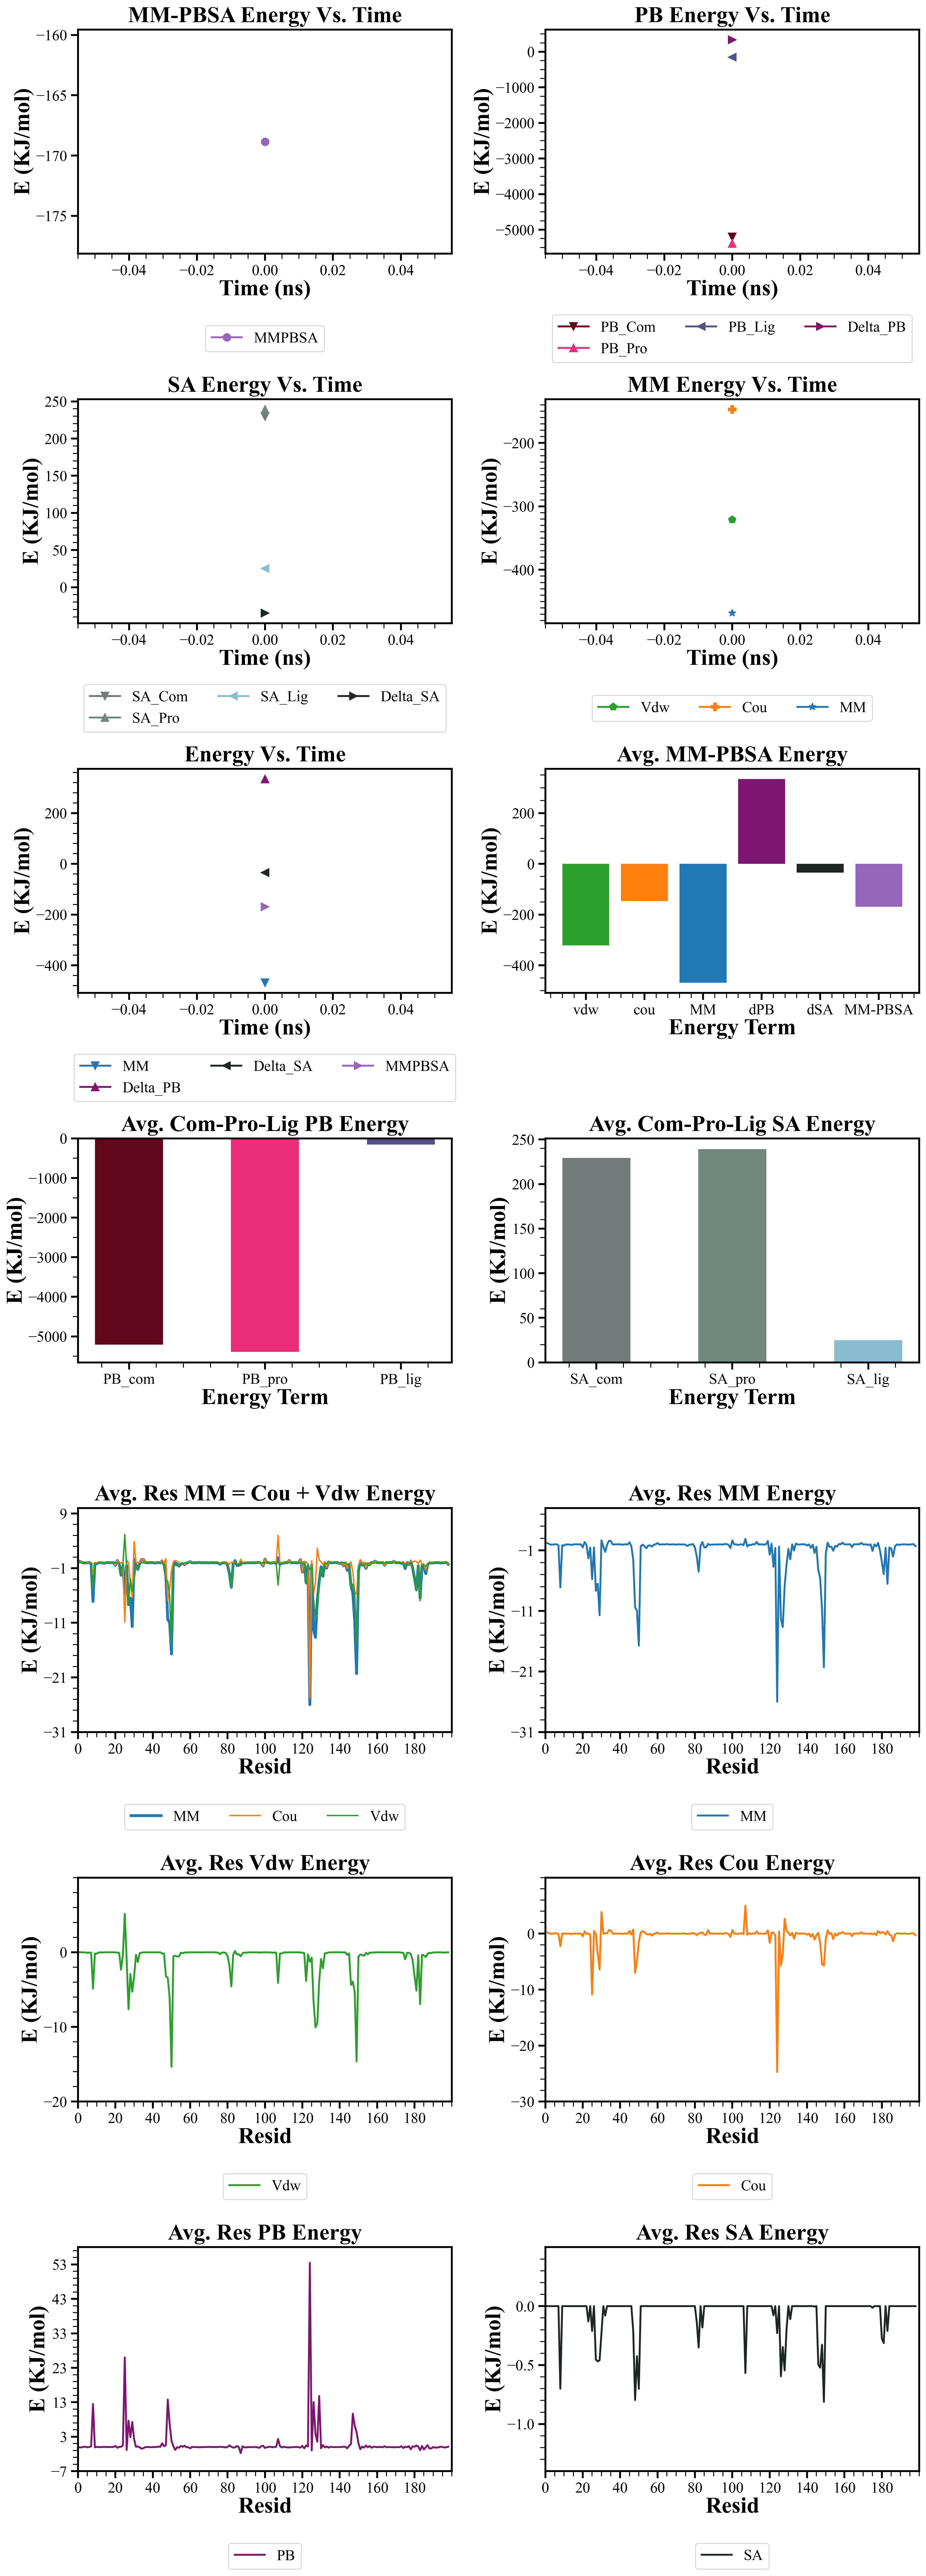

In [83]:
figs,axes=plt.subplots(7,2,figsize=(16,45))


axes[0,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["MM-PBSA"].iloc[:-2], marker="o",color=colorset["MMPBSA"])
axes[0,0].set_title("MM-PBSA Energy Vs. Time")
axes[0,0].set_xlabel("Time (ns)")
axes[0,0].set_ylabel("E (KJ/mol)")
axes[0,0].yaxis.set_minor_locator(MultipleLocator(5))
axes[0,0].tick_params(axis="x",direction="out")
axes[0,0].tick_params(axis="y",direction="out")
axes[0,0].legend(["MMPBSA"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[0,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["PB_com"].iloc[:-2], marker="v",color=colorset["PBCom"])
axes[0,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["PB_pro"].iloc[:-2], marker="^",color=colorset["PBPro"])
axes[0,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["PB_lig"].iloc[:-2], marker="<",color=colorset["PBLig"])
axes[0,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["dPB"].iloc[:-2], marker=">",color=colorset["PB"])
axes[0,1].set_title("PB Energy Vs. Time")
axes[0,1].set_xlabel("Time (ns)")
axes[0,1].set_ylabel("E (KJ/mol)")
axes[0,1].yaxis.set_minor_locator(MultipleLocator(250))
axes[0,1].tick_params(axis="x",direction="out")
axes[0,1].tick_params(axis="y",direction="out")
axes[0,1].legend(["PB_Com","PB_Pro","PB_Lig","Delta_PB"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[1,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["SA_com"].iloc[:-2], marker="v",color=colorset["SACom"])
axes[1,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["SA_pro"].iloc[:-2], marker="^",color=colorset["SAPro"])
axes[1,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["SA_lig"].iloc[:-2], marker="<",color=colorset["SALig"])
axes[1,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["dSA"].iloc[:-2], marker=">",color=colorset["SA"])
axes[1,0].set_title("SA Energy Vs. Time")
axes[1,0].set_xlabel("Time (ns)")
axes[1,0].set_ylabel("E (KJ/mol)")
axes[1,0].yaxis.set_minor_locator(MultipleLocator(10))
axes[1,0].tick_params(axis="x",direction="out")
axes[1,0].tick_params(axis="y",direction="out")
axes[1,0].legend(["SA_Com","SA_Pro","SA_Lig","Delta_SA"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[1,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["vdw"].iloc[:-2], marker="p",color=colorset["Vdw"])
axes[1,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["cou"].iloc[:-2], marker="P",color=colorset["Cou"])
axes[1,1].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["MM"].iloc[:-2], marker="*",color=colorset["MM"])
axes[1,1].set_title("MM Energy Vs. Time")
axes[1,1].set_xlabel("Time (ns)")
axes[1,1].set_ylabel("E (KJ/mol)")
axes[1,1].yaxis.set_minor_locator(MultipleLocator(10))
axes[1,1].tick_params(axis="x",direction="out")
axes[1,1].tick_params(axis="y",direction="out")
axes[1,1].legend(["Vdw","Cou","MM"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")


axes[2,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["MM"].iloc[:-2], marker="v",color=colorset["MM"])
axes[2,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["dPB"].iloc[:-2], marker="^",color=colorset["PB"])
axes[2,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["dSA"].iloc[:-2], marker="<",color=colorset["SA"])
axes[2,0].plot(totalPBSA["Time(ns)"].iloc[:-2],totalPBSA["MM-PBSA"].iloc[:-2], marker=">",color=colorset["MMPBSA"])
axes[2,0].set_title("Energy Vs. Time")
axes[2,0].set_xlabel("Time (ns)")
axes[2,0].set_ylabel("E (KJ/mol)")
axes[2,0].yaxis.set_minor_locator(MultipleLocator(40))
axes[2,0].tick_params(axis="x",direction="out")
axes[2,0].tick_params(axis="y",direction="out")
axes[2,0].legend(["MM","Delta_PB","Delta_SA","MMPBSA"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

errkw={"ecolor":"black","elinewidth":1.0,"capthick":1.0,"capsize":5}
axes[2,1].bar(totalPBSA.columns[[7,8,10,12,13,14]],totalPBSA.iloc[-2,[7,8,10,12,13,14]],yerr=totalPBSA.iloc[-1,[7,8,10,12,13,14]],error_kw=errkw,color=[colorset["Vdw"],colorset["Cou"],colorset["MM"],colorset["PB"],colorset["SA"],colorset["MMPBSA"]])
axes[2,1].set_title("Avg. MM-PBSA Energy")
axes[2,1].set_xlabel("Energy Term")
axes[2,1].set_ylabel("E (KJ/mol)")
axes[2,1].yaxis.set_minor_locator(MultipleLocator(50))
axes[2,1].tick_params(axis="x",direction="out")
axes[2,1].tick_params(axis="y",direction="out")

axes[3,0].bar(totalPBSA.columns[1:4],totalPBSA.iloc[-2,1:4],yerr=totalPBSA.iloc[-1,1:4],width=0.5,error_kw=errkw,color=[colorset["PBCom"],colorset["PBPro"],colorset["PBLig"]])
axes[3,0].set_title("Avg. Com-Pro-Lig PB Energy")
axes[3,0].set_xlabel("Energy Term")
axes[3,0].set_ylabel("E (KJ/mol)")
axes[3,0].yaxis.set_minor_locator(MultipleLocator(500))
axes[3,0].tick_params(axis="x",direction="out")
axes[3,0].tick_params(axis="y",direction="out")

axes[3,1].bar(totalPBSA.columns[4:7],totalPBSA.iloc[-2,4:7],yerr=totalPBSA.iloc[-1,4:7],width=0.5,error_kw=errkw,color=[colorset["SACom"],colorset["SAPro"],colorset["SALig"]])
axes[3,1].set_title("Avg. Com-Pro-Lig SA Energy")
axes[3,1].set_xlabel("Energy Term")
axes[3,1].set_ylabel("E (KJ/mol)")
axes[3,1].yaxis.set_minor_locator(MultipleLocator(20))
axes[3,1].tick_params(axis="x",direction="out")
axes[3,1].tick_params(axis="y",direction="out")

axes[4,0].plot(avgresPBSA["resid"][:-1],avgresPBSA["MM"][:-1],linewidth=3,color=colorset["MM"])
axes[4,0].plot(avgresPBSA["resid"][:-1],avgresPBSA["cou"][:-1],linewidth=1.5,color=colorset["Cou"])
axes[4,0].plot(avgresPBSA["resid"][:-1],avgresPBSA["vdw"][:-1],linewidth=1.5,color=colorset["Vdw"])
axes[4,0].set_title("Avg. Res MM = Cou + Vdw Energy")
axes[4,0].set_xlabel("Resid")
axes[4,0].set_ylabel("E (KJ/mol)")
axes[4,0].minorticks_on()
axes[4,0].tick_params(axis="x",direction="out")
axes[4,0].tick_params(axis="y",direction="out")
axes[4,0].set_xticks(np.arange(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1,20))
axes[4,0].set_xlim(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1)
axes[4,0].set_yticks(np.arange(round(avgresPBSA[["vdw","cou","MM"]][:-1].min().min())-5,round(avgresPBSA[["vdw","cou","MM"]][:-1].max().max())+5,10))
axes[4,0].set_ylim(round(avgresPBSA[["vdw","cou","MM"]][:-1].min().min())-5,round(avgresPBSA[["vdw","cou","MM"]][:-1].max().max())+5)
axes[4,0].legend(["MM","Cou","Vdw"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[4,1].plot(avgresPBSA["resid"][:-1],avgresPBSA["MM"][:-1],color=colorset["MM"])
axes[4,1].set_title("Avg. Res MM Energy")
axes[4,1].set_xlabel("Resid")
axes[4,1].set_ylabel("E (KJ/mol)")
axes[4,1].minorticks_on()
axes[4,1].tick_params(axis="x",direction="out")
axes[4,1].tick_params(axis="y",direction="out")
axes[4,1].set_xticks(np.arange(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1,20))
axes[4,1].set_xlim(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1)
axes[4,1].set_yticks(np.arange(round(avgresPBSA["MM"][:-1].min())-5,round(avgresPBSA["MM"][:-1].max())+5,10))
axes[4,1].set_ylim(round(avgresPBSA["MM"][:-1].min())-5,round(avgresPBSA["MM"][:-1].max())+5)
axes[4,1].legend(["MM"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[5,0].plot(avgresPBSA["resid"][:-1],avgresPBSA["vdw"][:-1],color=colorset["Vdw"])
axes[5,0].set_title("Avg. Res Vdw Energy")
axes[5,0].set_xlabel("Resid")
axes[5,0].set_ylabel("E (KJ/mol)")
axes[5,0].minorticks_on()
axes[5,0].tick_params(axis="x",direction="out")
axes[5,0].tick_params(axis="y",direction="out")
axes[5,0].set_xticks(np.arange(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1,20))
axes[5,0].set_xlim(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1)
axes[5,0].set_yticks(np.arange(round(avgresPBSA["vdw"][:-1].min())-5,round(avgresPBSA["vdw"][:-1].max())+5,10))
axes[5,0].set_ylim(round(avgresPBSA["vdw"][:-1].min())-5,round(avgresPBSA["vdw"][:-1].max())+5)
axes[5,0].legend(["Vdw"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[5,1].plot(avgresPBSA["resid"][:-1],avgresPBSA["cou"][:-1],color=colorset["Cou"])
axes[5,1].set_title("Avg. Res Cou Energy")
axes[5,1].set_xlabel("Resid")
axes[5,1].set_ylabel("E (KJ/mol)")
axes[5,1].minorticks_on()
axes[5,1].tick_params(axis="x",direction="out")
axes[5,1].tick_params(axis="y",direction="out")
axes[5,1].set_xticks(np.arange(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1,20))
axes[5,1].set_xlim(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1)
axes[5,1].set_yticks(np.arange(round(avgresPBSA["cou"][:-1].min())-5,round(avgresPBSA["cou"][:-1].max())+5,10))
axes[5,1].set_ylim(round(avgresPBSA["cou"][:-1].min())-5,round(avgresPBSA["cou"][:-1].max())+5)
axes[5,1].legend(["Cou"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[6,0].plot(avgresPBSA["resid"][:-1],avgresPBSA["PB"][:-1],color=colorset["PB"])
axes[6,0].set_title("Avg. Res PB Energy")
axes[6,0].set_xlabel("Resid")
axes[6,0].set_ylabel("E (KJ/mol)")
axes[6,0].minorticks_on()
axes[6,0].tick_params(axis="x",direction="out")
axes[6,0].tick_params(axis="y",direction="out")
axes[6,0].set_xticks(np.arange(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1,20))
axes[6,0].set_xlim(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1)
axes[6,0].set_yticks(np.arange(round(avgresPBSA["PB"][:-1].min())-5,round(avgresPBSA["PB"][:-1].max())+5,10))
axes[6,0].set_ylim(round(avgresPBSA["PB"][:-1].min())-5,round(avgresPBSA["PB"][:-1].max())+5)
axes[6,0].legend(["PB"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")

axes[6,1].plot(avgresPBSA["resid"][:-1],avgresPBSA["SA"][:-1],color=colorset["SA"])
axes[6,1].set_title("Avg. Res SA Energy",fontstyle="normal")
axes[6,1].set_xlabel("Resid")
axes[6,1].set_ylabel("E (KJ/mol)")
axes[6,1].minorticks_on()
axes[6,1].tick_params(axis="x",direction="out")
axes[6,1].tick_params(axis="y",direction="out")
axes[6,1].set_xticks(np.arange(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1,20))
axes[6,1].set_xlim(avgresPBSA["resid"][0]-1,avgresPBSA["resid"].iloc[-1]+1)
axes[6,1].set_yticks(np.arange(round(avgresPBSA["SA"][:-1].min())-0.5,round(avgresPBSA["SA"][:-1].max())+0.5,0.5))
axes[6,1].set_ylim(round(avgresPBSA["SA"][:-1].min())-0.4,round(avgresPBSA["SA"][:-1].max())+0.5)
axes[6,1].legend(["SA"],ncol=3,bbox_to_anchor=(0.5,-0.38),loc="center")


figs.suptitle("Summary of MM-PBSA",fontsize=36,fontweight="bold",x=0.5,y=0.93)
figs.savefig("Summary.png")

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        save_subfig(figs,axes[i][j],axes[i][j].get_title()+".png")

In [40]:
axes.shape

(7, 2)

---

Total electrostatic energy = Fixed charge energy + Mobile charge energy + Dielectric energy   
Fixed charge energy= the sum of per-atom energies    
Elec_DH    Multiple Debye-Huckel sphere boundary conditions    
Elec_BCF   Boundary conditions from focusing  使用该能量！  